## Model refinement / new approaches
Test a multi-class classification approach.


In [2]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/prototype/')
import prepare_data as pp
import run_preds as rp
import large_feats as lf
import score_classifier as sc
import visualize as viz
import os
import glob
from catboost import CatBoostClassifier
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import seaborn as sns
import rasterio as rs
from rasterio.merge import merge
from datetime import datetime

%load_ext autoreload
%autoreload 2

# Multi-class Classification Pipeline

In [10]:
# train classification cat model with multi-class data (v14 and v15)
X, y = pp.create_xy(['v14', 'v15'], classes='multi', drop_prob=False, drop_feats=False, verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v15')

53.0 unknown plots dropped
Plot id 14027 has no cloud free imagery and will be removed.
2.0 unknown plots dropped
Training data includes 244 plots.
Class count {0.0: 5044, 1.0: 1319, 2.0: 41461}


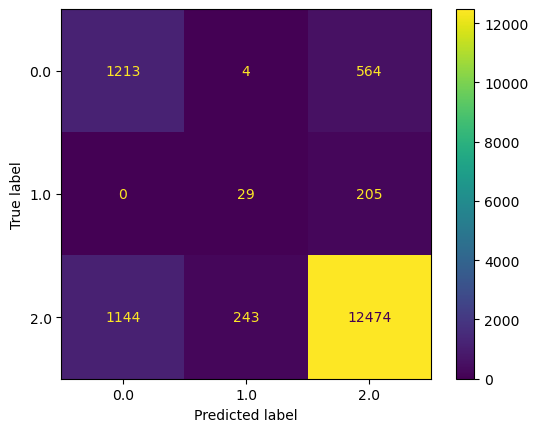

In [12]:
# check out results
with open(f'../models/cat_v15.pkl', 'rb') as file:  
    model = pickle.load(file)

# Confusion Matrix
cm = confusion_matrix(y_test, pred, labels=model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot();

In [14]:
# train regression model with multi-class data (v14 and v15)
# applies manual scaling

X, y = pp.create_xy(['v14', 'v15'], classes='multi', drop_prob=False, drop_feats=False, verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_and_scale_manual(X, y, 'v15')

In [15]:
df = rp.fit_eval_regressor(X_train_ss, X_test_ss, y_train, y_test, 'rfr','v15')

In [16]:
df

,model,class,cv,train_score,test_score,roc_auc,precision,recall,f1,date
0,rfr_v15,n/a,0.2128,0.9535,0.1946,NaN,NaN,NaN,NaN,2023-01-24


In [23]:
import hickle as hkl
feats_file = f'../tmp/ashanti/1658/1098/raw/feats/1658X1098Y_feats.hkl'
feats_raw = hkl.load(feats_file).astype(np.float32)

# adjust TML predictions feats[0] to match training data (0-1)
# adjust shape by rolling axis (65, 614, 618) ->  (618, 614, 65) 
feats_raw[0] = feats_raw[0] / 100 
feats_raw[1:] = feats_raw[1:] / 1000  # feats are multiplyed by 1000 before saving
feats_rolled = np.rollaxis(feats_raw, 0, 3)
feats_rolled = np.rollaxis(feats_rolled, 0, 2)

In [31]:
X, y = pp.create_xy(['v14', 'v15'], classes='multi', drop_prob=False, drop_feats=False, verbose=True)
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)

53.0 unknown plots dropped
Plot id 14027 has no cloud free imagery and will be removed.
2.0 unknown plots dropped
Training data includes 244 plots.
Class count {0.0: 5044, 1.0: 1319, 2.0: 41461}


In [33]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [34]:
class_weights

{0.0: 3.2636632955358054, 1.0: 9.81505376344086, 2.0: 0.3858454106280193}

In [36]:
y_test, pred, probs, probs_pos = rp.fit_eval_multiclassifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v15')

# Adapt Multi-class Labels for Binary Classification Pipeline

In [102]:
# pull in one of the labels plots and confirm how the change will be made
# look at labels for plot 15044
idx = '15044'
directory = '../data/train-labels/'
multi_labels = np.load(directory + str(idx) + '.npy')
binary_labels = multi_labels.copy()
binary_labels[binary_labels == 2] = 1
multi_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1])

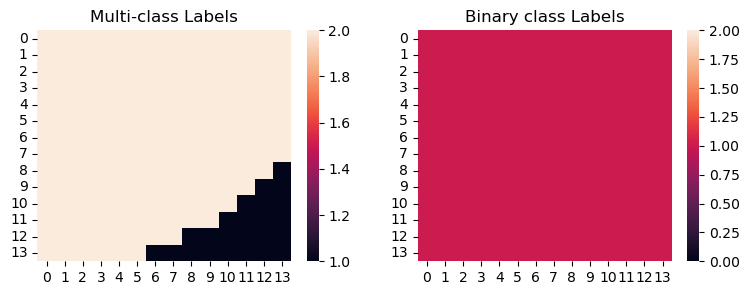

In [94]:
plt.figure(figsize=(9,3)) 

ax1 = plt.subplot(1,2,1)
sns.heatmap(multi_labels.reshape(14,14))
plt.title('Multi-class Labels');

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
sns.heatmap(binary_labels.reshape(14,14), vmin=0.0, vmax=2.0)
plt.title('Binary class Labels');

In [33]:
# train classification cat model that combines the single and multi class training data
X, y = pp.create_xy(['v08', 'v11', 'v14', 'v15'], classes='binary', drop_prob=False, drop_feats=False, verbose=True)

53.0 plots labeled unknown were dropped.
2.0 plots labeled unknown were dropped.
Plot id 08012 has no cloud free imagery and will be removed.
Plot id 08023 has no cloud free imagery and will be removed.
Plot id 08039 has no cloud free imagery and will be removed.
Plot id 08114 has no cloud free imagery and will be removed.
Plot id 08124 has no cloud free imagery and will be removed.
Plot id 08170 has no cloud free imagery and will be removed.
Plot id 08181 has no cloud free imagery and will be removed.
Plot id 08204 has no cloud free imagery and will be removed.
Plot id 08214 has no cloud free imagery and will be removed.
Plot id 08216 has no cloud free imagery and will be removed.
Plot id 08223 has no cloud free imagery and will be removed.
Plot id 14027 has no cloud free imagery and will be removed.
Training data includes 557 plots.
Class count {0.0: 30139, 1.0: 79033}


In [5]:
class_count = {0.0: 30139, 1.0: 79033}
scale_pos = class_count[0] / class_count[1]
scale_pos

0.3813470322523503

In [35]:
30139 / (30139 + 79033)

0.276068955409812

In [36]:
X_train_ss, X_test_ss, y_train, y_test = pp.reshape_no_scaling(X, y)
y_test, pred, probs, probs_pos = rp.fit_eval_classifier(X_train_ss, X_test_ss, y_train, y_test, 'cat','v15_2')

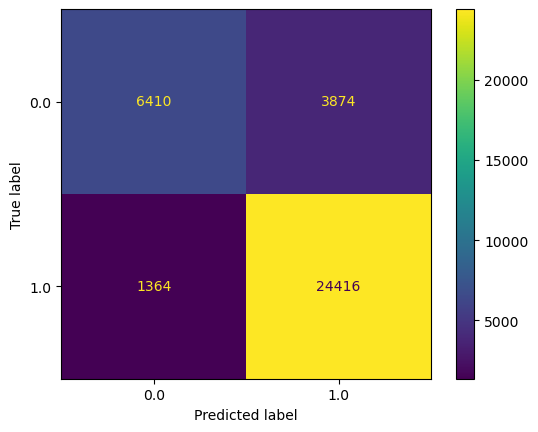

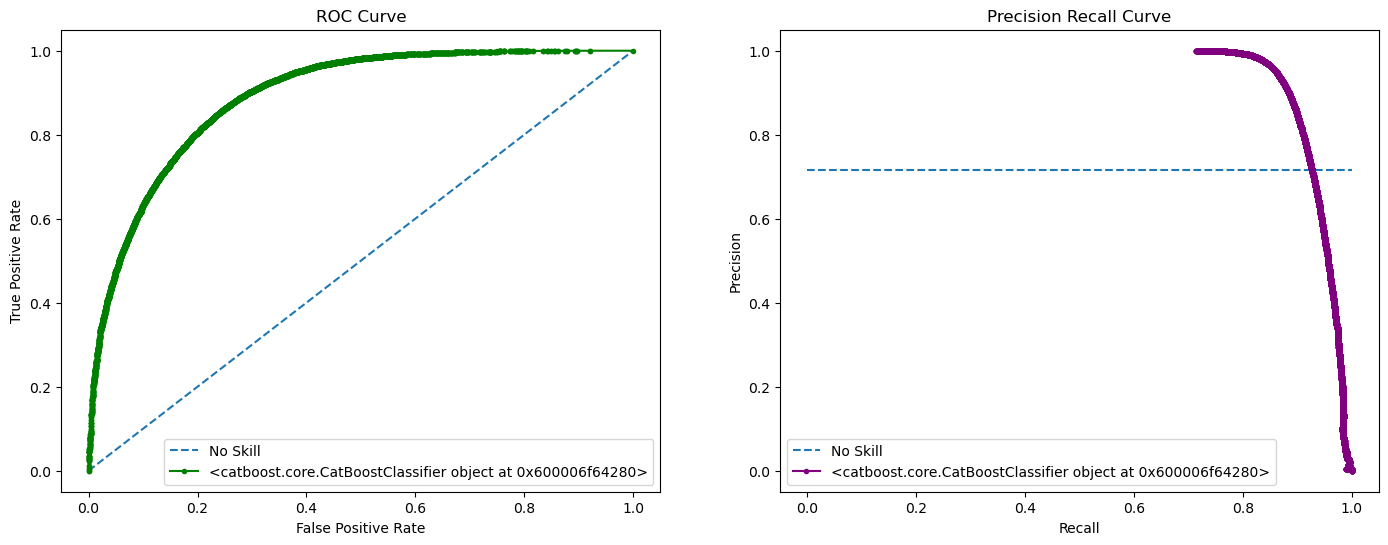

In [44]:
viz.cm_roc_pr('cat_v15_2', y_test, pred, probs_pos)